In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
from PIL import Image
from models.parsing import BiSeNet
from glob import glob
from utils.module import SpecificNorm, cosin_metric
from torchvision import transforms
from torchvision.transforms import Resize
from torchvision.transforms import functional as TF
import numpy as np
from tqdm import tqdm


face_dir = '/mnt/data1/joungbin/Arc2Face_data/original_image'
img_files = glob(f'{face_dir}/*/*.jpg')
# sort
img_files = sorted(img_files, key=lambda x: int(os.path.basename(os.path.dirname(x)).split('_')[-1]))


device = 'cuda' if torch.cuda.is_available() else 'cpu'

netSeg = BiSeNet(n_classes=19).to(device).eval()
spNorm = SpecificNorm().to(device).eval()
netSeg.load_state_dict(torch.load('/mnt/data2/jiwon/faceswap_unified/checkpoint/FaceParser.pth', weights_only=False))


# Attributes = [0, 'background', 1 'skin', 2 'r_brow', 3 'l_brow', 4 'r_eye', 5 'l_eye', 6 'eye_g', 7 'l_ear', 8 'r_ear', 9 'ear_r', 10 'nose', 11 'mouth', 12 'u_lip', 13 'l_lip', 14 'neck', 15 'neck_l', 16 'cloth', 17 'hair', 18 'hat']
color_list = [[0, 0, 0], [255, 0, 0], [0, 204, 204], [0, 0, 204], [255, 153, 51], [204, 0, 204], [255, 255, 0],
                [204, 0, 0], [102, 51, 0], [0, 0, 0], [76, 153, 0], [102, 204, 0], [255, 255, 0], [0, 0, 153],
                [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]

img_path = '/mnt/data2/jiwon/AnimateDiff/sample/strange_seg_sample/0_image.png'  # Change this to the desired image path
save_dir = os.path.dirname(img_path)
fname = os.path.basename(img_path)
img = Image.open(img_path).convert('RGB')
width, height = img.size
print(f'Processing {img_path} with size {width}x{height}')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
# transform = transforms.Compose([transforms.Resize((height, width)), transforms.ToTensor(),])

img_input = transform(img).to(device)
if len(img_input.shape) == 3:
    img_input = img_input.unsqueeze(0)
targ_mask = netSeg(spNorm(img_input))[0]
# targ_mask = transforms.Resize((height, width))(targ_mask)
parsing   = targ_mask.squeeze(0).detach().cpu().numpy().argmax(0)
targ_base = np.zeros((height, width, 3))
for idx, color in enumerate(color_list):
    targ_base[parsing == idx] = color

    


Processing /mnt/data2/jiwon/AnimateDiff/sample/strange_seg_sample/0_image.png with size 1024x1024


(-0.5, 1023.5, 1023.5, -0.5)

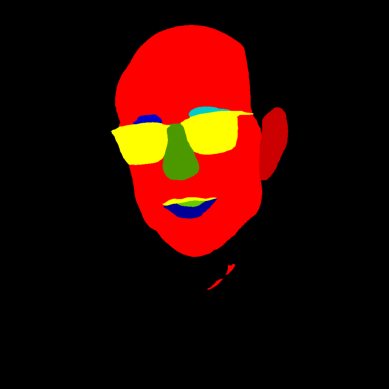

In [3]:
import matplotlib.pyplot as plt
plt.imshow(targ_base / 255.0)
plt.axis('off')